# Demo of Probabilistic Topological Maps and Extension
This notebook walks through some of the features implemented as a final project by Chris Bradley and Victoria Preston for 6.435 Bayesian Inference.

In [1]:
# imports
import itertools
import random
import copy
import operator
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import gaptopo_inference as ptm_lib
%matplotlib inline

## Initial Worlds
We have provided a few datasets that can be simply loaded for ease of this demonstration. We also have a simple default visualizer to actual inspect these datasets.

In [2]:
# can choose a pathalogical world
detection_locations, detection_covariances = ptm_lib.adversarial_world(1) #can choose 1, 2 or 3
proposal_topology = [tuple([i]) for i in range(0, len(detection_locations))] #group everything seperately

/home/vpreston/.local/lib/python2.7/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


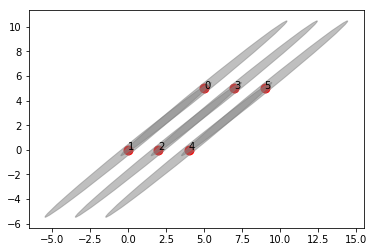

In [3]:
ptm_lib.plot_detections(T=proposal_topology, Z=detection_locations, Cov=detection_covariances)
plt.show()

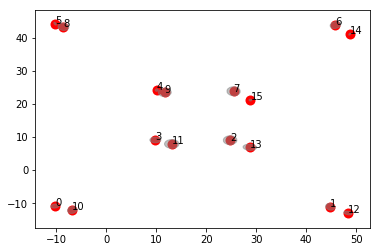

In [4]:
# can also choose simulated data
detection_locations, detection_covariances = ptm_lib.simulation_example_2() #can choose 1 or 2
proposal_topology = [tuple([i]) for i in range(0, len(detection_locations))] #group everything seperately
ptm_lib.plot_detections(T=proposal_topology, Z=detection_locations, Cov=detection_covariances)
plt.show()

## Sampler Distributions
Now, we can inspect the two distributions that form the basis of the Metropolis-Hastings sampler. First, let's inspect the proposal distribution. This selects between split and merge moves.

In [5]:
prop = [tuple([i]) for i in range(0, 10)]
print 'Initial Topology: ', prop
print '-----'
for i in xrange(10):
    prop, ratio, move_type = ptm_lib.draw_sample(prop)
    print 'Proposal Topology: ', prop
    print 'Proposal Ratio: ', ratio
    if move_type == 1:
        print 'Move Type: Merge'
    elif move_type == 2:
        print 'Move Type: Split'
    print '-----'

Initial Topology:  [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,)]
-----
Proposal Topology:  [(0,), (1,), (2,), (3,), (4,), (6,), (7,), (8,), (9, 5)]
Proposal Ratio:  45.0
Move Type: Merge
-----
Proposal Topology:  [(1,), (2,), (3,), (4,), (6,), (7,), (9, 5), (0, 8)]
Proposal Ratio:  18.0
Move Type: Merge
-----
Proposal Topology:  [(1,), (2,), (3,), (4,), (6,), (7,), (9, 5), (0, 8)]
Proposal Ratio:  0.0714285714286
Move Type: Split
-----
Proposal Topology:  [(1,), (2,), (4,), (7,), (9, 5), (0, 8), (6, 3)]
Proposal Ratio:  9.33333333333
Move Type: Merge
-----
Proposal Topology:  [(1,), (2,), (4,), (9, 5), (6, 3), (0, 8, 7)]
Proposal Ratio:  2.33333333333
Move Type: Merge
-----
Proposal Topology:  [(1,), (2,), (4,), (9, 5), (6, 3), (0, 8), (7,)]
Proposal Ratio:  0.428571428571
Move Type: Split
-----
Proposal Topology:  [(1,), (4,), (9, 5), (0, 8), (7,), (6, 3, 2)]
Proposal Ratio:  2.33333333333
Move Type: Merge
-----
Proposal Topology:  [(1,), (4,), (9, 5), (0, 8), (7,), (6,

The proposal ratio is purely a matter of combinatorics, and we can see that play out above. 

The posterior distribution is composed of several key elements, including a prior on landmark locations (the penalty function) and the likelihood function. The penalty function encodes the idea that landmarks in unique clusters should not lie close together. A non-zero penalty implies that there may be some vertices which require merging.

In [6]:
penalty = ptm_lib.location_prior(detection_locations, proposal_topology, max_range=2, max_penalty=10)
print penalty

3.7032060599505945


The likelihood function is a bit more complicated, and requires marginalizing over the topological vertex locations; these are where the detections are *expected* to be based upon a given topology. Since we don't generally have access to this, we need to perform an approximation. The ```posterior()``` function in the library will return the optimization samples, as well as the value of the approximated posterior evaluated for some topology.

Posterior Value:  [[1.21338428e-10]]


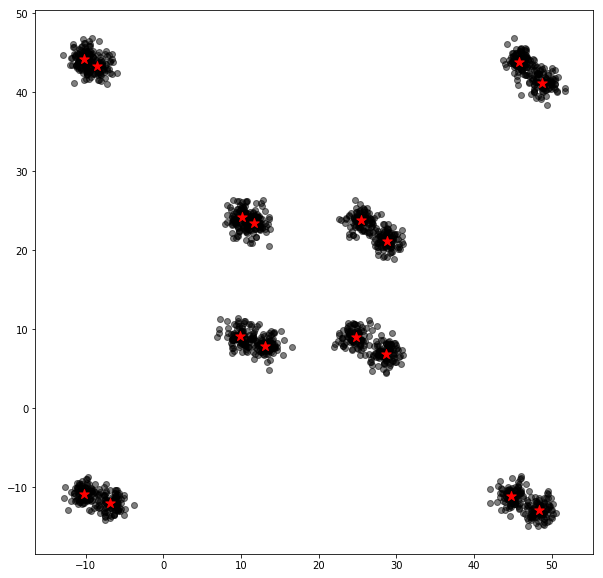

In [7]:
optimization_samples, posterior_value = ptm_lib.posterior(T=proposal_topology,
                                                          data=np.array(detection_locations),
                                                          cov=detection_covariances,
                                                          R=100,
                                                          sig_o=1.5,
                                                          sig_t=1.5,
                                                          max_range=2.,
                                                          max_penalty=10.)
plt.figure(figsize=(10,10))
for sample in optimization_samples:
    samp = sample.reshape(len(sample)/2,2)
    for s in samp:
        plt.scatter(s[0], s[1], c='k', alpha=0.5)
for loc in detection_locations:
    plt.scatter(loc[0], loc[1], c='r', marker='*', s=100)

print 'Posterior Value: ', posterior_value
plt.show()

Proposal Topology:  [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9), (10, 11), (12, 13), (14, 15)]
Posterior Value:  0.0


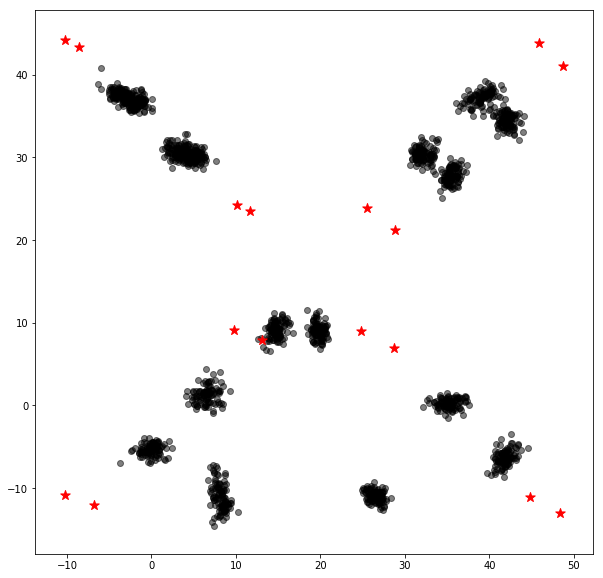

In [8]:
# we can also see what happens when merges are present
ids = np.linspace(0, len(detection_locations)-1, len(detection_locations))[0::2]
proposal_topology = [tuple([int(i), int(i+1)]) for i in ids]
optimization_samples, posterior_value = ptm_lib.posterior(T=proposal_topology,
                                                          data=np.array(detection_locations),
                                                          cov=detection_covariances,
                                                          R=100,
                                                          sig_o=1.5,
                                                          sig_t=1.5,
                                                          max_range=2.,
                                                          max_penalty=10.,
                                                          likelihood_type=None)
plt.figure(figsize=(10,10))
for sample in optimization_samples:
    samp = sample.reshape(len(sample)/2,2)
    for s in samp:
        plt.scatter(s[0], s[1], c='k', alpha=0.5)
for loc in detection_locations:
    plt.scatter(loc[0], loc[1], c='r', marker='*', s=100)

print 'Proposal Topology: ', proposal_topology
print 'Posterior Value: ', posterior_value
plt.show()

## The Sampler
With these elements in place, we can then use the MH sampler to move around the space. We've made a wrapper function which sets up the sampler with the proper parameters called PTM. The function will print a summary figure, a figure of the input world data that it uses, and will save to file (and return) the list of samples for further analysis.

Samples so far:  0
Samples so far:  100
Samples so far:  200
Samples so far:  300
Samples so far:  400
Samples so far:  500
Samples so far:  600
Samples so far:  700
Samples so far:  800
Samples so far:  900
(((0, 10), (1, 12), (2, 13), (3, 11), (4, 9), (5, 8), (6, 14), (7, 15)), 740)
(((0, 10), (1,), (2, 13), (3,), (4, 9), (5,), (6, 14), (7,), (8,), (11,), (12,), (15,)), 74)
(((0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,)), 45)


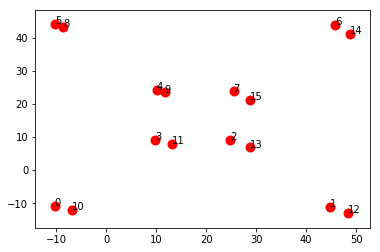

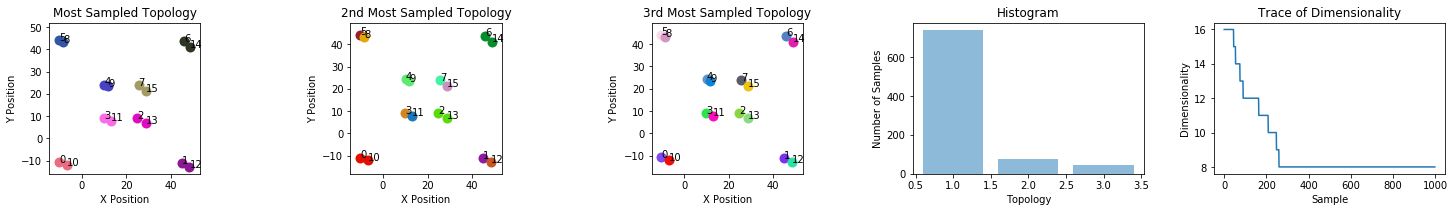

In [18]:
#Choose a World
detection_locations, detection_covariances = ptm_lib.simulation_example_2() #can choose 1 or 2
proposal_topology = [tuple([i]) for i in range(0, len(detection_locations))] #group everything seperately

#Set parameters
sig_o = 1.0
sig_t = 1.0
max_range = 10.0
max_penalty = 100.0
R = 30
number_of_samples = 1000

ptm = ptm_lib.PTM(T=proposal_topology,
                  Z=np.array(detection_locations),
                  posterior_func=ptm_lib.posterior,
                  niter=number_of_samples,
                  R=R,
                  sig_o=sig_o,
                  sig_t=sig_t,
                  max_range=max_range,
                  max_penalty=max_penalty,
                  visualize=True,
                  filename='ptm_samples')
plt.show()

## Extension
We've also added a method which considers not only the metric location, but the covariance of the landmark detections as well. This has a similar wrapper function which will take care of the parameterization as well.

Samples so far:  0
Samples so far:  100
Samples so far:  200
Samples so far:  300
Samples so far:  400
Samples so far:  500
Samples so far:  600
Samples so far:  700
Samples so far:  800
Samples so far:  900
(((0, 1), (2, 3), (4, 5)), 987)
(((0,), (1,), (2,), (3,), (4,), (5,)), 6)
(((0, 1), (2,), (3,), (4, 5)), 5)


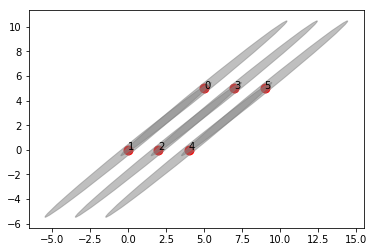

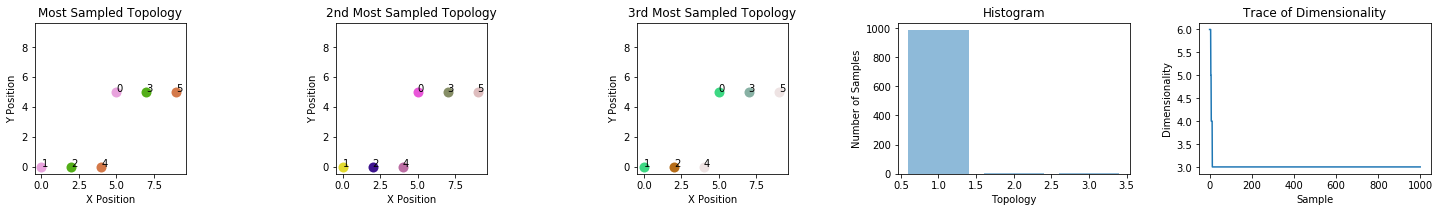

In [16]:
# Choose a World
detection_locations, detection_covariances = ptm_lib.adversarial_world(1) #can choose 1, 2 or 3
proposal_topology = [tuple([i]) for i in range(0, len(detection_locations))] #group everything seperately

# Set Params
sig_o = 2.5
sig_t = 1.5
max_range = 2.0
max_penalty = 50.0
R = 30
number_of_samples = 1000

#covPTM
extended_ptm = ptm_lib.covPTM(T=proposal_topology,
                              Z=np.array(detection_locations),
                              Cov=detection_covariances,
                              posterior_func=ptm_lib.posterior,
                              niter=number_of_samples,
                              R=R,
                              sig_o=sig_o,
                              sig_t=sig_t,
                              max_range=max_range,
                              max_penalty=max_penalty,
                              likelihood_type='Mahalanobis',
                              visualize=True,
                              filename='cptm_samples')

plt.show()